In [11]:
import pandas as pd
import awoc
from matplotlib import pyplot as plt
from core import DataLoader
from enums import PostType, VoteType

import warnings
warnings.filterwarnings('ignore')

In [11]:
Crypto = DataLoader('../data/crypto')

In [2]:
Christianity = DataLoader('../data/christianity')

In [3]:
Judaism = DataLoader('../data/judaism')

In [5]:
def get_tags(posts):
    tags = set()
    for tags_string in posts['Tags'].unique():
        if not tags_string:
            continue

        tags_ = tags_string.split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        tags.update(tags_)
    
    return tags

## Trudność uzyskania odznaki

Chcemy posortować odznaki względem trudności ich uzyskania. Miarą "trudności" będziemy liczyli średnią liczbę uzyskanych pozytywnych ocen przed uzyskaniem odznaki przez userów, kto już ją otrzymał.

Tablica ***Badges*** zawiera też odznaki, które mają takie same nazwy, co i tagi - takie odznaki zostały usunięte.

Funkcja zwracająca tablicę zawierającą nazwę odznaki i jej ***trudność*** do uzyskania:

In [9]:
def difficulty_getting_badge(db):
    badges = db.badges_df.copy()[['Name', 'UserId', 'Date']]
    posts = db.posts_df.copy()[['Id', 'OwnerUserId', 'CreationDate', 'Tags']]
    votes = db.votes_df.copy()[['PostId', 'VoteTypeId', 'CreationDate']]
    
    tags = get_tags(posts)
    
    badges = badges[~badges['Name'].isin(tags)]
    
    badges['Date'] = pd.to_datetime(badges['Date'])
    posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])
    
    first_badges = badges.loc[badges.groupby(['Name', 'UserId'])['Date'].idxmin()]
    
    badges_posts = first_badges.merge(posts, left_on='UserId', right_on='OwnerUserId')
    badges_posts = badges_posts[badges_posts['CreationDate'] < badges_posts['Date']][['Name', 'UserId', 'Date', 'Id']]
    
    badges_votes = badges_posts.merge(votes, left_on='Id', right_on='PostId')
    badges_votes = badges_votes[badges_votes['CreationDate'] < badges_votes['Date']]
    badges_up_votes = badges_votes[badges_votes['VoteTypeId'] == VoteType.UP][['Name', 'UserId']]
    
    s = badges_up_votes.groupby(['Name', 'UserId']).size()
    names = [x[0] for x in s.index]
    user_ids = [x[1] for x in s.index]
    d = pd.DataFrame({'BadgeName': names, 'UserId':user_ids, 'UPVotes':s.values})
    d = d.sort_values(['UPVotes']).groupby('BadgeName')['UPVotes'].mean()
    d = pd.DataFrame({'BadgeName': d.index, 'UPVotes': d.values}).sort_values('UPVotes', ascending=False)
    
    return d.reset_index()[['BadgeName', 'UPVotes']]

Znajdziemy "trudności" uzyskania każdej z odznak w zbiorze danych ***Crypto***:

In [12]:
df = difficulty_getting_badge(Crypto)

10 odznak najtrudniejszych do uzyskania:

In [13]:
df[:10]

,BadgeName,UPVotes
0,Socratic,6422.000000
1,Sheriff,3586.571429
2,Great Answer,2333.055556
3,Lifejacket,2321.823529
4,Populist,2025.333333
5,Synonymizer,2006.636364
6,Outspoken,1930.307692
7,Archaeologist,1908.400000
8,Refiner,1788.888889
9,Copy Editor,1685.875000


10 odznak najłatwiejszych do uzyskania:

In [14]:
df[-10:]

,BadgeName,UPVotes
73,Tumbleweed,17.582569
74,Popular Question,14.189790
75,Autobiographer,12.542838
76,Commentator,12.088818
77,Precognitive,7.200000
78,Scholar,3.972141
79,Supporter,3.965991
80,Editor,3.922631
81,Teacher,3.722061
82,Student,2.247622


Histogram średniej liczby pozytywnych ocen potrzebnych do otrzymania odznaki:

(array([60., 10.,  6.,  5.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([2.24762250e+00, 6.44222860e+02, 1.28619810e+03, 1.92817334e+03,
        2.57014857e+03, 3.21212381e+03, 3.85409905e+03, 4.49607429e+03,
        5.13804952e+03, 5.78002476e+03, 6.42200000e+03]),
 <BarContainer object of 10 artists>)

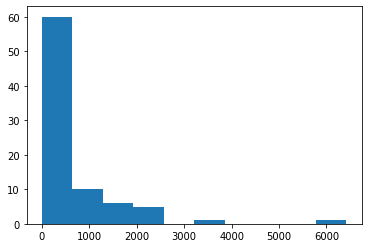

In [16]:
plt.hist(df['UPVotes'])

## Powiązane tagi

Próbujemy wśród wszystkich tagów występujących w zbiorze danych znaleźć takie, które są podtematem innych, np. tag ***python*** jest podtematem tagu ***programming***.

Żeby znaleźć takie tagi, dla każdych 2 tagów wyliczamy:
- liczbę postów z 1 tagiem
- liczbę postów z 2 tagiem
- liczbę postów z obydwoma tagami

Po czym na podstawie zebranych danych obliczamy jaki procent postów z tagiem pierwszym zawiera też tag drugi i na odwrót. Jeżeli ten procent jest odpowiednio duży, to zakładamy, że jeden z nich (z większym procentem) jest podtematem innego.

Reprezendacja drzewa powiązanych tagów wygląda następująco (tagi 2 i 3 są podtematami 1; 5 jest podtematem 4; 1 i 7 są niezależne):

Jeśli tag nie jest podtematem innego i nie zawiera podtematów, w reprezentacji drzewa go omijamy.

Funkcja znajdująca i wypisująca drzewo powiązanych tagów dla tabeli ***posts*** z dowolnego zbioru danych:

In [6]:
def find_sub_tags(posts_df, precision=.5):
    posts = posts_df
    
    tags = get_tags(posts)
    
    tag_n = {}
    for tag in tags:
        tag_n[tag] = len(posts[posts['Tags'].str.contains(f'<{tag}>', regex=False, na=False)])
    
    co_tags = {}
    for index, row in posts.iterrows():
        if not row['Tags']:
            continue

        tags_ = row['Tags'].split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        for tag1 in tags_:
            for tag2 in tags_:
                if tag1 >= tag2:
                    continue
                co_tags[(tag1, tag2)] = co_tags.get((tag1, tag2), 0) + 1
    
    likely_parent = {}
    for tag in tags:
        parent = None
        union_percent = 0

        for p in tags:
            if (nu := co_tags.get((min(tag, p), max(tag, p)))):
                if precision * 100 < (u_percent := nu / tag_n[tag] * 100) and u_percent > union_percent:
                    union_percent = u_percent
                    parent = p

        if parent:
            likely_parent[tag] = parent

    likely_children = {}
    for tag in likely_parent.values():
        likely_children[tag] = []
        for child, p in likely_parent.items():
            if tag == p:
                likely_children[tag].append(child)
    
    class Node:
        def __init__(self, name):
            self.name = name
            self.children = []
            self.parent = None

        def show(self, offset=0):
            print(self.name, end='')

            if self.children:
                print()
                for child in self.children:
                    print(' ' * (offset + len(self.name) - 1) + '|- ', end='')
                    child.show(offset + len(self.name) + 2)

            print()
    
    nodes = [Node(t) for t in tags]
    
    for parent, children in likely_children.items():
        parent = [node for node in nodes if node.name == parent][0]
        for child in children:
            child = [node for node in nodes if node.name == child][0]
            child.parent = parent
            parent.children.append(child)
        parent.children.sort(key=lambda x: x.name)
    
    nodes.sort(key=lambda x: x.name)
    for parent in nodes:
        if parent.parent is None and parent.children:
            parent.show()

Znajdziemy powiązane tagi ze zbioru danych ***Christianity***:

In [7]:
find_sub_tags(Christianity.posts_df.copy())

abraham
      |- isaac
      |- sarah

acts
   |- ananias-and-sapphira
   |- council-of-jerusalem

adam-and-eve
           |- garden-of-eden

aliens
     |- humans

angels
     |- 4-living-creatures
     |- archangels
     |- guardian-angels

anglicanism
          |- articles-of-religion

apologetics
          |- bart-ehrman
          |- ces-letter
          |- isaac-of-troki
          |- presuppositionalism

apostles
       |- matthias

apostolic-fathers
                |- fornication
                             |- litany

                |- pre-nicene-fathers

archaeology
          |- paleography

arianism
       |- theodosius

arius
    |- st.-nicholas
                  |- santa-claus


atonement
        |- penal-substitution
        |- ransom-theory
        |- recapitulation-theory

baptism
      |- infants
      |- jesus-name-baptism
      |- paedobaptism

bible
    |- biblical-fiction
    |- book-of-life
    |- versification

bible-commentary
               |- matthew-henry

bib

Możemy w wyniku zobaczyć ścieżki wygenerowane przez ten algorytm, np. ***catholicism - virgin-mary - assumption-of-mary***.

Bardzo ważny jest ***minimalny procent czułości***, tzn. minimalny procent który jest potrzebny, by stwierdzić, że jeden tag jest podtematem innego. Im on jest większy, tym mniej zależności zostanie znaleziono ale prawdopodobieństwo, że są rzeczywiście związane będzie większe. Z drugiej strony im on jest mniejszy, tym więcej mniej jawnych zależności możemy odnaleźć.

Wartością domyślną tego procentu jest 0.5 (***50%***), jak zmniejszymy go do 0.1 (***10%***) zaobserwujemy następujące drzewo:

In [8]:
find_sub_tags(Christianity.posts_df.copy(), .1)

bible
    |- applications
    |- bible-reading
    |- bible-translation
                       |- copyright
                       |- esv
                            |- nasb

                       |- kjv
                            |- kjv-onlyism
                            |- niv
                            |- nkjv

                       |- nrsv
                       |- septuagint
                                   |- masoretic-text

                       |- textual-criticism

    |- biblical-fiction
    |- biblical-reliability
    |- book-of-life
    |- canon
           |- book-of-enoch
           |- deuterocanonical-books
           |- gospel-of-thomas
           |- protestant-bible
           |- pseudepigrapha

    |- inerrancy
    |- inspiration
    |- scriptures
                |- churches
                          |- sanctity

                |- printing-press

    |- versification

biblical-basis
             |- church-of-the-nazarene
             |- church-offices
        

Możemy na przykład zobaczyć, że tag ***church-history*** nie tylko pojawił się w tym drzewie, ale i jest bardzo rozbudowany.

## Najpopularniejsze tagi w regionach

Chcemy wyznaczyć najpopularniejsze tagi w różnych regionach świata, tzn. w Europie, Azji, Afryce, Północnej i Południowej Amerykach.

Pod popularnością tagu rozumiemy liczbę pozytywnych ocen postów i odpowiedzi na nie z tym tagiem.
Za lokalizację postu z tagiem bierzemy lokalizację autora. Niestety nie wszystkie użytkowniki w swojej lokalizacji mają nazwę kraju, więc takie posty nie będą brane pod uwagę.

Funkcja zwracająca tablicę zawierającą nazwę tagu i jego popularność w każdym regionie:

In [3]:
def tags_popularity(db):
  up_votes = db.votes_df[db.votes_df['VoteTypeId'] == VoteType.UP][['Id', 'PostId']].groupby('PostId').count()
  posts_with_upvotes = pd.merge(db.posts_df, up_votes, left_on='Id', right_on='PostId')
  answers_with_upvotes = posts_with_upvotes[posts_with_upvotes['PostTypeId'] == PostType.ANSWER]\
    [['ParentId', 'Id_y']].groupby('ParentId').sum()

  posts_with_tags = db.posts_df[db.posts_df['PostTypeId'] == PostType.QUESTION][['Id', 'OwnerUserId', 'Tags']]\
  .dropna(subset=['OwnerUserId'], inplace=False)

  posts_with_tags_upvotes = pd.merge(posts_with_tags, up_votes, left_on='Id', right_on='PostId')
  posts_with_tags_upvotes = pd.merge(posts_with_tags_upvotes, answers_with_upvotes, left_on='Id_x', right_on='ParentId')
  posts_with_tags_upvotes['UpVotes'] = posts_with_tags_upvotes['Id_y_x'] + posts_with_tags_upvotes['Id_y_y']
  posts_with_tags_upvotes = posts_with_tags_upvotes[['Id_x', 'OwnerUserId', 'UpVotes', 'Tags']]\
  .convert_dtypes()
  posts_with_tags_upvotes_location = pd.merge(posts_with_tags_upvotes, db.users_df, left_on='OwnerUserId', right_on='Id')[['Location', 'UpVotes_x', 'Tags']]\
  .dropna(subset=['Location'], inplace=False)

  tag_popularity_europe = {}
  tag_popularity_north_america = {}
  tag_popularity_south_america = {}
  tag_popularity_asia = {}
  tag_popularity_africa = {}

  world = awoc.AWOC()
  for _, post in posts_with_tags_upvotes_location.iterrows():
    if any(map(post['Location'].__contains__, world.get_countries_list_of('North America'))):
      for tag in post['Tags'].replace('>', ' ').replace('<', ' ').split():
        tag_popularity_north_america[tag] = tag_popularity_north_america.get(tag, 0) + post['UpVotes_x']
      continue
    if any(map(post['Location'].__contains__, world.get_countries_list_of('Europe'))):
      for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
        tag_popularity_europe[tag] = tag_popularity_europe.get(tag, 0) + post['UpVotes_x']
      continue
    if any(map(post['Location'].__contains__, world.get_countries_list_of('South America'))):
      for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
        tag_popularity_south_america[tag] = tag_popularity_south_america.get(tag, 0) + post['UpVotes_x']
      continue
    if any(map(post['Location'].__contains__, world.get_countries_list_of('Asia'))):
      for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
        tag_popularity_asia[tag] = tag_popularity_asia.get(tag, 0) + post['UpVotes_x']
      continue
    if any(map(post['Location'].__contains__, world.get_countries_list_of('Africa'))):
      for tag in post.loc['Tags'].replace('>', ' ').replace('<', ' ').split():
        tag_popularity_africa[tag] = tag_popularity_africa.get(tag, 0) + post['UpVotes_x']
  tag_popularity = pd.DataFrame({'TagName': tag_popularity_europe.keys(), 'PopularityInEurope': tag_popularity_europe.values()})
  tag_popularity = pd.merge(tag_popularity, pd.DataFrame({'TagName': tag_popularity_south_america.keys(), 'PopularityInSouthAmerica': tag_popularity_south_america.values()}), how='outer')
  tag_popularity = pd.merge(tag_popularity, pd.DataFrame({'TagName': tag_popularity_asia.keys(), 'PopularityInAsia': tag_popularity_asia.values()}), how='outer')
  tag_popularity = pd.merge(tag_popularity, pd.DataFrame({'TagName': tag_popularity_africa.keys(), 'PopularityInAfrica': tag_popularity_africa.values()}), how='outer')
  tag_popularity = pd.merge(tag_popularity, pd.DataFrame({'TagName': tag_popularity_north_america.keys(), 'PopularityInNorthAmerica': tag_popularity_north_america.values()}), how='outer')\
    .fillna(0)\
    .convert_dtypes()
  return tag_popularity

Znajdziemy popularność tagów w każdym regionie dla serwisu ***Christianity***

In [4]:
tag_popularity = tags_popularity(Christianity)

Weźmy 4 najpopularniejsze tagi z każdego regionu

In [5]:
tag_count = 4
top_tag_popularity_europe = tag_popularity.sort_values(by='PopularityInEurope', ascending=False).head(tag_count)
top_tag_popularity_north_america = tag_popularity.sort_values(by='PopularityInNorthAmerica', ascending=False).head(tag_count)
top_tag_popularity_south_america = tag_popularity.sort_values(by='PopularityInSouthAmerica', ascending=False).head(tag_count)
top_tag_popularity_africa = tag_popularity.sort_values(by='PopularityInAfrica', ascending=False).head(tag_count)
top_tag_popularity_asia = tag_popularity.sort_values(by='PopularityInAsia', ascending=False).head(tag_count)
top_tag_popularity = pd.merge(top_tag_popularity_europe, top_tag_popularity_north_america, how='outer')
top_tag_popularity = pd.merge(top_tag_popularity, top_tag_popularity_south_america, how='outer')
top_tag_popularity = pd.merge(top_tag_popularity, top_tag_popularity_asia, how='outer')
top_tag_popularity = pd.merge(top_tag_popularity, top_tag_popularity_africa, how='outer').fillna(0)

Narysujmy wykres najpopularniejszych tagów pogrupowanych po regionach

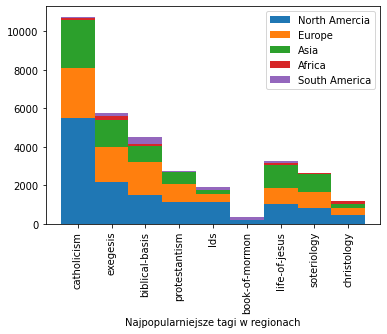

In [6]:
bar_width = 1
r = range(0, len(top_tag_popularity))
bottom1 = top_tag_popularity['PopularityInNorthAmerica']
bottom2 = bottom1 + top_tag_popularity['PopularityInEurope']
bottom3 = bottom2 + top_tag_popularity['PopularityInAsia']
bottom4 = bottom3 + top_tag_popularity['PopularityInAfrica']
plt.bar(r, top_tag_popularity['PopularityInNorthAmerica'], width=bar_width, label='North Amercia')
plt.bar(r, top_tag_popularity['PopularityInEurope'], bottom=bottom1, width=bar_width, label='Europe')
plt.bar(r, top_tag_popularity['PopularityInAsia'], bottom=bottom2, width=bar_width, label='Asia')
plt.bar(r, top_tag_popularity['PopularityInAfrica'], bottom=bottom3, width=bar_width, label='Africa')
plt.bar(r, top_tag_popularity['PopularityInSouthAmerica'], bottom=bottom4, width=bar_width, label='South America')
plt.xlabel('Najpopularniejsze tagi w regionach')
plt.xticks(r, top_tag_popularity['TagName'], rotation='vertical')
plt.legend()
plt.show()

Z tego wykresu możemy zrobić wstępnie następujące wnioski:
1. W Azji jest wiele chrześcijan, szczególnie katolików i zainteresowanych tą religią
2. Mormony występują w większości w Amerykach
3. Ten serwis jest najbardziej popularny w Ameryce Północnej

## Związek wzrostów użycia tagów z wydarzeniami światu rzeczywistego

Chcemy przeanalizować związek między wzrostem częstotliwości wystąpienia postów z wybranymi tagami w latach a wydarzeniami na świecie związanymi z tymi tagami. W tym celu najpierw obliczymy rozkład częstotliwości pojawienia się postów posiadających przekazane tagi.

Funkcja zwracająca ilość wystąpień postów z tagami **tags**.

In [20]:
def tags_accuracy_by_years(data, tags):
    posts = data.posts_df.set_index('Id')
    posts_with_tags = posts[posts.Tags.str.contains('|'.join(tags), na=False)]
    posts_with_tags.CreationDate = pd.to_datetime(posts_with_tags.CreationDate)
    result = pd.DataFrame({
        'CreationYear': posts_with_tags.CreationDate.dt.year})
    return result.groupby(['CreationYear'])['CreationYear'].size()

Spróbujemy znaleźć wzrosty wystąpień tagów związanych z LGBT w latach, kiedy miały miejsce poważne protesty przeciwko dyskryminacji.

<AxesSubplot:xlabel='CreationYear'>

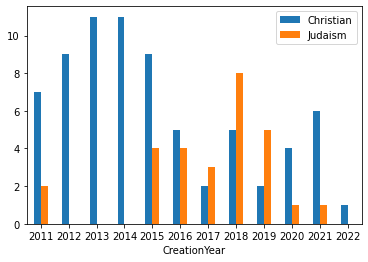

In [21]:
tags = ['<homosexuality>', '<pride>']

chris = tags_accuracy_by_years(Christianity, tags)
jud = tags_accuracy_by_years(Judaism, tags)

result = pd.DataFrame({'Christian': chris, 'Judaism': jud})
result.plot.bar(rot=0)

Widzimy mocny wzrost częstotliwości pojawienia się tagów w 2014 roku dla zbioru danych z forumu o chrześcijaństwie, który może być związany z protestami podczas igrzysk olimpijskiсh (https://en.wikipedia.org/wiki/LGBT_rights_protests_surrounding_the_2014_Winter_Olympics).

Również możemy obserwować wsrost w 2018 roku dla zbioru z forumu o judaizmie. Ten wzrost może być związany z protestami w Izraelu (https://en.wikipedia.org/wiki/2018_Israeli_LGBT%27s_strike#:~:text=On%20July%2022%2C%202018%20Israeli,towards%20the%20Israeli%20trans%20community).

Teraz spróbujemy sprawdzić, czy wzrost wystąpień LGBT-tagów w 2018 roku rzeczywiście jest związany z protestami w Izraelu. W tym celu znajdziemy rozkład częstotliwości wystąpień ww. tagów w krajach w 2018 roku.

Funkcja zwracająca iłość wystąpień postów z tagami **tags** w roku **year** w **n_countries** krajach wskazanych przez największą iłość użytkowników.

In [22]:
def tags_accuracy_by_countries_at_year(data, tags, year, n_countries):
    users = pd.concat([Christianity.users_df, Judaism.users_df], sort=False)
    countries = [c for c in calculate_countries(users, n_countries) if type(c) == str]

    posts = data.posts_df.set_index('OwnerUserId')
    users = data.users_df.set_index('Id')
    users = standardize_countries(users)
    
    df = posts.merge(users, left_on='OwnerUserId', right_on='Id', how='inner', suffixes=('Posts', 'Users'))
    df.CreationDatePosts = pd.to_datetime(df.CreationDatePosts)

    posts_with_tags = df[df.Tags.str.contains('|'.join(tags), na=False) 
        & (df.Location.str.contains('|'.join(countries), na=False)) 
        & (df.CreationDatePosts.dt.year == year)]
    result = pd.DataFrame({
        'Country': posts_with_tags.Location})

    return result.groupby(by=result.Country).size()

Funkcja zwracająca **n_countries** krajów wskazanych przez największą iłość użytkowników.

In [23]:
def calculate_countries(users, n_countries):
    users = standardize_countries(users)
    s = users.groupby(['Location']).size()
    d = pd.DataFrame({'Country': s.index, 'Number': s.values})
    d = d.sort_values(by=['Number'], ascending=False)
    
    return d['Country'][:n_countries]

Skoro serwisy StackExchange pozwolają użytkownikom na wprowadzenie czegokolwiek do pola **Location**, żeby usyzkać rozsądne dane do analizy musimy przeprowadzić pewną normalizację tych danych. Ta normalizacja będzie polegała na poszukiwaniu w pole **Location** podciągów zawierających nazwę albo skrót krainy i oraz podmianie tego pola na zapowiedzianą nazwę kraju.

Funkcja przyjmująca dataframe **users** i zwracająca ten sam dataframe o znormalizowanym polu **Location**.

In [24]:
def standardize_countries(users):
    aliases = {
        'USA': ['USA', 'US', 'United States'],
        'UK': ['UK', 'United Kingdom', 'GB', 'Great Britain'],
        'Israil': ['Israil', 'Israel'],
        'France': ['France'],
        'Germany': ['Germany'],
        'India': ['India'],
        'Thailand': ['Thai'],
        'Indonesia': ['Indonesia'],
        'Brazil': ['Brazil'],
        'Australia': ['Australia'],
        'Canada': ['Canada'],
        'Poland': ['Poland'],
        'Russia': ['Russia'],
    }
    
    for alias, names in aliases.items():
        for country in names:
            users['Location'] = users['Location'].apply(
                lambda x: alias 
                if x and country in str(x) 
                else x)

    users['Location'] = users['Location'].apply(
        lambda x: x[x.rindex(','):].replace(',', '').replace(' ', '') 
        if type(x) == str and ',' in x 
        else x)
    
    return users
            

Spróbujemy znaleźć iłość wystąpień LGBT-tagów w 2018 roku w 50 krajach o największej liczbie użytkowników.

<AxesSubplot:xlabel='Country'>

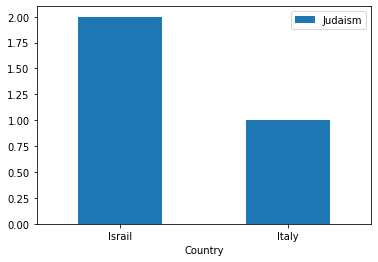

In [25]:
tags = ['<homosexuality>', '<pride>']
n_countries = 50
year = 2018

jud = tags_accuracy_by_countries_at_year(Judaism, tags, year, n_countries)

result = pd.DataFrame({'Judaism': jud})

result.plot.bar(rot=0)

Otrzymane wyniki mogą wydawać się dziwne. Rzeczywiście, pierwsza część analizy pokazała, że w 2018 roku powstały 8 postów, przecież spośród 50 krajów o największej iłości użytkowników znaleźliśmy tylko 3 posty o podanych tagach. Jednak da się wyprowadzić z tego kilka ważnych wniosków:

1. W skutek tego, że wybrany zbiór danych nie ma ustawionego formatu lokalizacji, analiza tych danych jest bardzo utrudniona, a zaimplementowany algorytm normalizacji jest nie wystarczająco *mądry*. Również możemy stwierdzić, że wybrany dataset nie odpowiada tej analizie, ponieważ nie udało się znaleźć wystarczjąco dużo pasujących tagów i postów odpowiadających im.

2. Nie wykryliśmy wzrostu wykorzystania wybranych tagów w Izraelu, a zatem wzrost wystąpień LGBT-tagów w 2018 roku nie jest związany z protestami. Czyli, w badanym zbiorze danych nie ma zależności pomiędzy częstotliwością wystąpienia postów z wybranymi tagami w latach a wydarzeniami na świecie związanymi z tymi tagami.